# LRP-gamma

In this notebook, I try to implement LRP gamma without using gradients.

The advantage of not using gradients is, that it is possible to compute gradients of functions that depend on heatmaps. Since pytorch does not allow to compute gradients of gradients, it's the only way to do it.

`cifar10_utils.py` contains the net and dataloaders of the pytorch [https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-download-beginner-blitz-cifar10-tutorial-py](cifar10 tutorial). Additionally, it contains `input_times_gradient(net, images, target_pattern)` and `plot_heatmaps(images, heatmaps)`. The idea is to analyze their trained network using LRP-gamma.

Let's prepare the implementation and load a trained network.

In [1]:
%matplotlib inline
from cifar10_utils import *

Files already downloaded and verified
Files already downloaded and verified


In [2]:
net = Net()
net.load("cifar10net")
accuracy = net.accuracy(testloader)
print("Accuracy:", accuracy)
print("Class Accuracy:", net.class_accuracy(testloader))

Accuracy: 0.5268
Class Accuracy: {'plane': 0.5869017632241813, 'car': 0.7869674185463659, 'bird': 0.31690140845070425, 'cat': 0.2810126582278481, 'deer': 0.33164556962025316, 'dog': 0.5699208443271768, 'frog': 0.517162471395881, 'horse': 0.5382585751978892, 'ship': 0.7306733167082294, 'truck': 0.5280612244897959}


We will be dealing with different heatmapping techniques. The functions that generate them have the regular name, and objects that contain heatmaps will be called `h_<shortname>`.

Now, let's implement deeptaylor.
We need the forward activations, so let's rewrite the network class a bit.

We want to add rules to layers that depend on their actications during the forwarding.
So we wrap the forwarding and create a number of `ExplainableLayer`s. Then we create a class for models that support deep taylor decompositions.

We can use it by subclassing from `ExplainableLayer` and adding the architecture there, like in the example `ExplainNet` which is a copy of `cifar10utils.Net`. But if we also want to use existing trained models, we can use `ExplainableLayer.from_model`.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([10, 10])
(Linear) -> torch.Size([10, 84])
(Linear)     Conservation error: 1.0
(LinearRelu) -> torch.Size([10, 120])
(LinearRelu)     Conservation error: 1.0000001192092896
(LinearRelu) -> torch.Size([10, 400])
(LinearRelu)     Conservation error: 1.0000001192092896
(MaxPool) -> torch.Size([10, 16, 10, 10])
(MaxPool)     Conservation error: 1.0
(ConvRelu) -> torch.Size([10, 6, 14, 14])
(ConvRelu)     Conservation error: 0.9999998807907104
(MaxPool) -> torch.Size([10, 6, 28, 28])
(MaxPool)     Conservation error: 1.000000238418579
(10, 3, 32, 32)


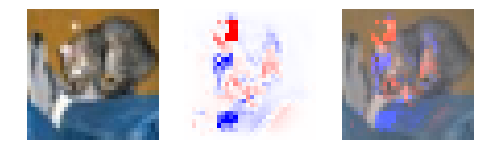

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


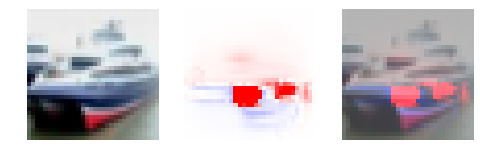

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


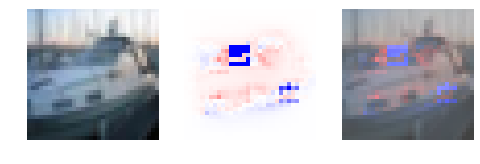

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


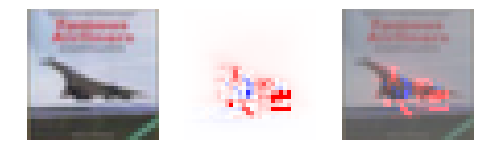

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


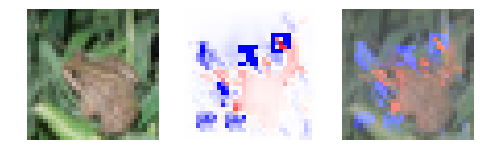

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


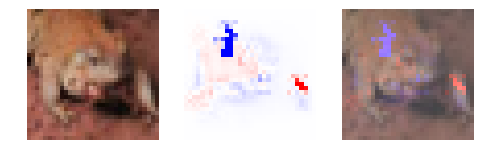

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


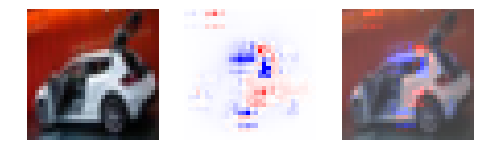

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


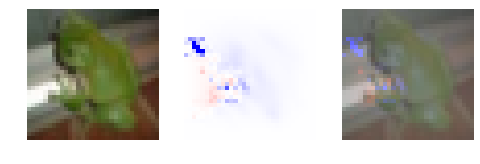

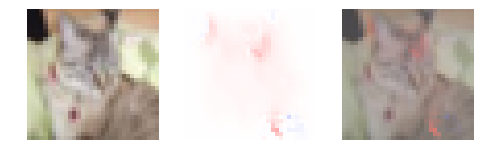

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


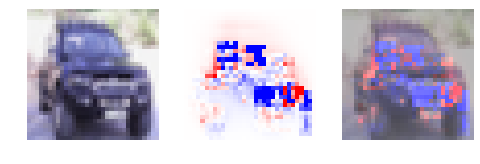

In [27]:
import torch.nn.functional as F
from torch import nn
import numpy as np
import copy
import pdb

na = None


class ExplainableLayer():
    """
    Base class for all layers that support deeptaylor
    """
    @classmethod
    def from_module(cls, src):
        layer = copy.deepcopy(src)
        layer.__class__ = cls
        return layer


class ReluLayer(ExplainableLayer, nn.Module):
    """
    Base class for layers that support Deep Taylor Decomposition
    Saves the input, a and z
    """
    def forward(self, x):
        self.x = x
        self.a = super().forward(x) # Super is called from a child class and via dependency injection this will be eg nn.Linear's forward layer 
        self.z = F.relu(self.a)
        return self.z
        
    
class Linear(ExplainableLayer, nn.Linear):
    """
    For linear layers without Relu activation, usually the last
    """
    def forward(self, x):
        D = np.prod(x.shape[1:])
        self.x = x
        x = x.view(-1, D)
        self.a = super().forward(x) # Super is called from a child class and via dependency injection this will be eg nn.Linear's forward layer 
        self.z = self.a
        return self.z
    
    def zplus(self, R, eps=1e-9):
        w_plus = F.relu(self.weight) # (D, d)
        z_plus = F.linear(self.x, w_plus, None)
        R_norm = R/(z_plus+eps) # (N, d)
        return F.linear(R_norm, w_plus.transpose(0, 1))*self.x
    
    def zb(self, R, l, h, eps=1e-9):
        w_plus  = F.relu(self.weight)
        w_minus = -F.relu(-self.weight)
        norm = self.z - l*F.linear(self.x, w_plus) - h*F.linear(self.x, w_minus)
        R_norm = R/norm
        return F.linear(R_norm, self.weight.transpose(0, 1))  \
            - l*F.linear(R_norm, self.w_plus.transpose(0, 1)) \
            - h*F.linear(R_norm, self.w_minus.transpose(0, 1))


class LinearRelu(ReluLayer, Linear):
    """
    Implements deep taylor rules for linear layers
    """
    def forward(self, x):
        D = np.prod(x.shape[1:])
        return super().forward(x.view(-1, D))
    
    
class ConvRelu(ReluLayer, nn.Conv2d):
    """
    Implements deep taylor for conv2d layers
    """
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.conv_args = {
            'padding': self.padding,
            'stride': self.stride
        }
        
    def zplus(self, R, eps=1e-9):
        w_plus = F.relu(self.weight) # (D, d)
        z_plus = F.conv2d(self.x, w_plus, **self.conv_args)
        R_norm = R/(z_plus+eps) # (N, d)
        R_out_norm = F.conv_transpose2d(R_norm, w_plus, **self.conv_args)
        return R_out_norm*self.x
    
    def zb(self, R, l, h, eps=1e-9):
        w_plus  = F.relu(self.weight)
        w_minus = -F.relu(-self.weight)
        norm = self.z - l*F.conv2d(self.x, w_plus, **self.conv_args) \
                        - h*F.conv2d(self.x, w_minus, **self.conv_args)
        R_norm = R/norm
        return F.conv_transpose2d(R_norm, self.weight, **self.conv_args)  \
            - l*F.conv_transpose2d(R_norm, w_plus, **self.conv_args) \
            - h*F.conv_transpose2d(R_norm, w_minus, **self.conv_args)
    
    @classmethod
    def from_module(cls, src):
        layer = copy.deepcopy(src)
        layer.__class__ = cls
        layer.conv_args = {
            'padding': layer.padding,
            'stride': layer.stride
        }
        return layer
    

class MaxPool(ReluLayer, nn.MaxPool2d):
    """
    Maxpool2d layer with the interface of the explainable ReluLayer
    """
    def get_flat_inverse(self):
        """
        Returns a weight tensor that can be used to perform sum pooling or
        deconvolution that distributes everything evenly among input cells
        """
        if hasattr(self, '_flat_inverse'):
            return self._flat_inverse
        
        if isinstance(self.kernel_size, int):
            kernel_size = (self.kernel_size, self.kernel_size, )
        else:
            kernel_size = self.kernel_size
        
        c = self.z.shape[1]
        
        channel_ii = np.ones(kernel_size)/np.prod(kernel_size)
        weight = np.zeros([c, c]+list(kernel_size)) + np.eye(c)[...,na,na]*channel_ii[na,na,...]
        weight = torch.from_numpy(weight).float()
        
        self._flat_inverse = weight
        return self._flat_inverse
    
    def zplus(self, R, eps=1e-9):
        # distribute relevance flat to all input fields
        weight = self.get_flat_inverse()
        
        R_prop = F.conv_transpose2d(R, weight,
                padding=self.padding, stride=self.stride)
        return R_prop
    
    @staticmethod
    def from_module(src):
        return MaxPool(kernel_size=src.kernel_size,
                      stride=src.stride,
                      padding=src.padding,
                      dilation=src.dilation,
                      return_indices=False,
                      ceil_mode=src.ceil_mode
                      )
    
    
class ExplainableModel(TrainableNet):
    """
    Base class for networks that implement deep taylor decomposition.
    Network architecture is not specified here
    """
    def __init__(self, layers, min_x=-1, max_x=1):
        """
        Layers: Instances of subclasses of ReluLayer
        min_x, max_x: Box constraints of the input domain
        """
        super().__init__()
        self.layers = layers
        self.min_x, self.max_x = min_x, max_x
        
    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x
    
    def layer_shapes(self, x):
        print(x.shape)
        for layer in self.layers:
            x = layer.forward(x)
            print(f"({layer.__class__.__name__}) ->", x.shape)
        return x
    
    def deeptaylor(self, x, pattern):
        out = self.forward(images)
        R = out*pattern
        R_total = R.sum()
        print(R.shape)
        for layer in self.layers[1:][::-1]:
            R = R.view(layer.z.shape)
            R = layer.zplus(R)
            print(f"({layer.__class__.__name__}) ->", R.shape)
            print(f"({layer.__class__.__name__})     Conservation error: {R.sum()/R_total}")
        R = self.layers[0].zb(R, self.min_x, self.max_x)
        return R
    
    @classmethod
    def from_model(cls, model, layer_names):
        """
        model: nn.Module
        layer_names: list[string] contains the property names of the mappings that define the network
        eg: if model.forward does this:
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            x = x.view(-1, 16 * 5 * 5)
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = self.fc3(x)
        layer_names should look like this:
        ['conv1', 'pool', 'conv2', 'pool', 'fc1', 'fc2', 'fc3']
        
        Relus don't have to be specified:
            assumes that relus are used everywhere but in the last layer
            assumes the last layer is linear
        Reshaping does not have to be specified
        
        Relies on the fact that each ReluLayer is also subclass of the class of model
        """
        def casted_layer(src, last_layer=False):
            # finds the Explainable equivalent of src.__class__
            if last_layer:
                return Linear.from_module(src)
            for layer_type in ReluLayer.__subclasses__():
                if issubclass(layer_type, src.__class__):
                    return layer_type.from_module(src)
        
        # cast all layers
        # all but the last are casted to relu layers
        layers = [casted_layer(model._modules[l]) for l in layer_names[:-1]] + \
                 [casted_layer(model._modules[layer_names[-1]], last_layer=True)]
        
        # now create a ExplainBase object which we call self, and pretend to be a constructor
        self = cls(layers)
        # add the layers to the properties of self, in hope that 
        # pytorch transforms it to a self._modules element
        for l, layer in zip(layer_names, layers):
            self.__dict__[l] = layer
            
        return self

enet = ExplainableModel.from_model(net, ['conv1', 'pool', 'conv2', 'pool', 'fc1', 'fc2', 'fc3'])
dataiter = iter(testloader)
images, labels = dataiter.next()
h_dtd = enet.deeptaylor(images, one_hot(labels))
predictions = enet.forward()
plot_heatmaps(images, h_dtd.sum(1), labels, predictions)

In [26]:
print(h_dtd.shape)
h_itg = input_times_gradient(net, images, one_hot(labels))
print(h_itg.shape)
#plot_heatmaps(images, h_itg)

torch.Size([10, 3, 32, 32])
torch.Size([10, 32, 32])


/Users/nielswarncke/Documents/pytorch-tuts/cifar10_utils.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(images, requires_grad=True)


Let's check if the from_model works:

In [ ]:
enet = ExplainableModel.from_model(net, ['conv1', 'pool', 'conv2', 'pool', 'fc1', 'fc2', 'fc3'])
accuracy = enet.accuracy(testloader)
print("Accuracy:", accuracy)
print("Class Accuracy:", net.class_accuracy(testloader))

Great!

Here is an example how we can add the architecture by subclassing:

In [ ]:
   
class ExplainNet(ExplainableModel):
    """
    Rebuilt of cifar10utils.Net with deep taylor support
    """
    def __init__(self):
        layers = [
            ConvRelu(3, 6, 5),
            MaxPool(2, 2),
            ConvRelu(6, 16, 5),
            MaxPool(2, 2),
            LinearRelu(16 * 5 * 5, 120),
            LinearRelu(120, 84),
            LinearRelu(84, 10)
        ]
        super().__init__(layers, -1, 1)
        
        # Because pytorch is weird, the submodels cannot be stored in a list
        self.l1 = layers[0]
        self.l2 = layers[1]
        self.l3 = layers[2]
        self.l4 = layers[3]
        self.l5 = layers[4]
        self.l6 = layers[5]
            
        

enet_sister = ExplainNet()
enet_sister.train(1, trainloader)
dataiter = iter(testloader)
images, labels = dataiter.next()
h_dtd = enet_sister.deeptaylor(images, one_hot(labels))

Let's try to generate some heatmaps:

In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()
h_dtd = enet.deeptaylor(images, one_hot(labels))

In [11]:
#issubclass(enet.layers[1].__class__ , nn.MaxPool2d)
#help(nn.Conv2d)
net.conv1.weight.shape

torch.Size([6, 3, 5, 5])